In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Simulation notes
For the simulation, the time is following this convention:
1 time unit = 10 ms


## Single stimulation for different excitabilities with inhibitory stimulation
<a name="single_stim_single_exc"></a>
Simulation of a train pulse stimulation with different exctabilities


In [37]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) -z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))


# sim parameters
dt = 0.001
t_sim_init = 1000
n_samples_init = int(t_sim_init/dt)
t_sim = 1600
n_samples = int(t_sim/dt)
upsamp = 10
t = np.linspace(0, t_sim, t_sim*upsamp)

# stim parameters
t_start = 400
I_duration = .3
Is1 = -2
Is2 = -5
        
# 8 seconds at 20Hz and 8 seconds at 40Hz
lI_inter = np.array([5, 2.5]) - I_duration
ln_stim = np.array([20*8, 40*8])
lllq = []
for I_inter in lI_inter:
    print(I_inter)
    llq = []
    for n_stim in ln_stim:
        print(n_stim)

        # Parameters
        parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
                      'tau':10, 'a2':6, 'c2':0.3, 'm':0,
                      'x0':-2.25, 'r':0.00005, 's':4,
                      'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

        # Find initial conditions by root solving
        q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
        q = fsolve(epileptor, q0, args=parameters)

        stim = 1
        parameters['Is2'] = 0
        for it in range(n_samples_init):
            # Runge-Kutta scheme
            p1 = epileptor(q, parameters)
            p2 = epileptor(q+(dt/2)*p1, parameters)
            p3 = epileptor(q+(dt/2)*p2, parameters)
            p4 = epileptor(q+(dt/2)*p3, parameters)
            q += dt/6 * (p1+2*p2+2*p3+p4)

        lq = []
        for it in range(n_samples):
            # if it%10000==0:
            #     print(it)
            tc = it*dt

            tstim = 0
            if stim:
                for i_stim in range(n_stim):
                    if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                        tstim = 1
            if tstim:
                parameters['Is2'] = Is2
                parameters['Is1'] = Is1
            else:
                parameters['Is1'] = 0
                parameters['Is2'] = 0

            # Runge-Kutta scheme
            p1 = epileptor(q, parameters)
            p2 = epileptor(q+(dt/2)*p1, parameters)
            p3 = epileptor(q+(dt/2)*p2, parameters)
            p4 = epileptor(q+(dt/2)*p3, parameters)
            q += dt/6 * (p1+2*p2+2*p3+p4)

            if it%int(1/(upsamp*dt))==0:
                lq.append(q.copy())
        llq.append(lq)
    lllq.append(llq)
lllq = np.array(lllq)

4.7
160
320
2.2
160
320


In [38]:
lllq.shape
lfreq_stim = np.round(100/(np.array(lI_inter+I_duration))) # from 10 ms time step I_inter to freq

### Time series

In [39]:
ts.shape

(12, 5, 20000)

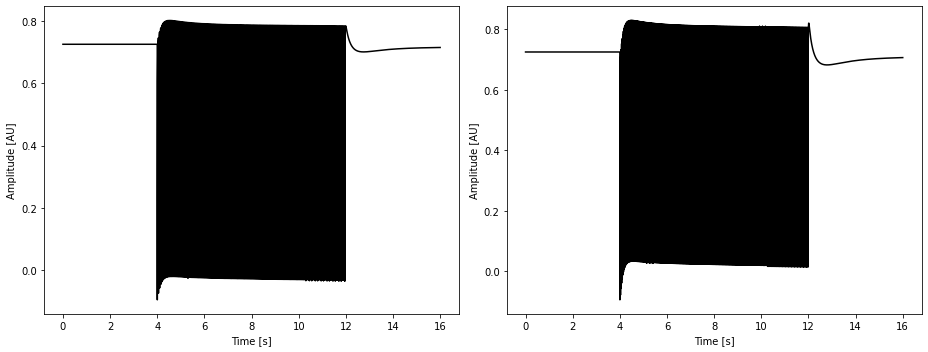

In [47]:
ts = -lllq[:, :, :, 0] + lllq[:, :, :, 3]
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(t/100, ts[0, 0], color='k')
# plt.xlim([0, 1])
# plt.ylim([0, 2.5])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [AU]')
plt.subplot(1, 2, 2)
plt.plot(t/100, ts[1, 1], color='k')
#plt.xlim([0, 1])
# plt.ylim([0, 2.5])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [AU]')
plt.tight_layout()
plt.savefig('figures/train_stim_inhi_time_series.svg')